In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
# I use torch geometric data objects to handle graph data
# See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for installation details
from torch_geometric.data import Data, DataLoader

# Data set creation

### Creating raw data set

In [2]:
# We are given with a data set consisting of raw EEG data with N channels and D ms duration
N = 32
D = 500
# There are 'n_patients = [n_hc, n_sz, n_avh]' people in a data set
# HC = healthy people, SZ = schizophrenia, AVH = schizophrenia + hallucinations
n_hc = 30
n_sz = 12
n_avh = 10
n_patients = [n_hc, n_sz, n_avh]
# Each patient has multiple recordings
n_exp = 30
# Let's generate raw data
# EEG data can be significantly out of [-1,1] => we will need normalization
create_dataset = lambda n,e: 19*np.random.randn(n, e, N, D)
dataset_raw = [create_dataset(n, n_exp) for n in n_patients]

### Labeling

In [3]:
# Assume 1 data point corresponds to 1 ms
# Assume signal (e.g. auditory signal) is given at t = 250
# Hence, we can split each signal into 2 parts: t = [0, 249] - resting, t = [250, 499] - listening

# We define disease-related labels as 'is_schizophrenia' & 'has_hallucinations'
# It corresponds to y_hc = [0,0], y_sz = [1,0], y_avh = [1,1]

### Calculating functional connectivity matrix

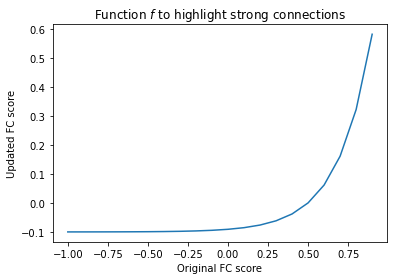

In [4]:
# (Optional) function to map [-1,1] -> [-0.1, 1] 
# It drastically decreases resolution for [-1,0.5] range
# Motivation: we are interested only in highly connected links
f = lambda t: -0.1 + 0.00909091*121**t
plt.plot(np.arange(-1,1,0.1), f(np.arange(-1,1,0.1)))
plt.xlabel('Original FC score')
plt.ylabel('Updated FC score')
plt.title('Function $f$ to highlight strong connections');

In [5]:
def get_fc(eeg_data):
    N, D = eeg_data.shape
    fc_adj = np.corrcoef(eeg_data) # Pearson's correlation coefficient as connectivity measure
    fc_adj = f(fc_adj) # Highligting strong connections
    fc_adj = fc_adj - np.eye(N,N) #Remove self-self connections
    return fc_adj

### Creating data sets

In [6]:
hc_dataset_raw, sz_dataset_raw, avh_dataset_raw = dataset_raw # given raw data
hc_dataset, sz_dataset, avh_dataset = [], [], [] # data sets to train a model

In [7]:
for patient_data in hc_dataset_raw:
    for experiment_data in patient_data:
        experiment_data = (experiment_data + 100)/200 # [-100,100] -> [-1,1] minmax normalization
        signal_0 = experiment_data[:,:250] # resting part
        signal_1 = experiment_data[:,250:] # listening part
        
        adj_0 = get_fc(signal_0) 
        adj_1 = get_fc(signal_1)
        
        y_0 = [0,0,0] # resting, no schizophrenia, no hallucinations
        y_1 = [1,0,0] # listening, no schizophrenia, no hallucinations
        
        # data must have following components:
        #     x (torch.float.Tensor) : raw EEG signal of shape [N, D]
        #     adj (torch.float.Tensor) : FC matrix of shape [1, N, N]
        #     y (torch.long.Tensor) : binary label vector of shape [1, 3] 
        data_0 = Data(x = torch.tensor(signal_0).float(), adj = torch.tensor(adj_0).float().unsqueeze(0), y = torch.tensor(y_0).float().unsqueeze(0))
        data_1 = Data(x = torch.tensor(signal_1).float(), adj = torch.tensor(adj_1).float().unsqueeze(0), y = torch.tensor(y_1).float().unsqueeze(0))
        
        hc_dataset.append(data_0)
        hc_dataset.append(data_1)
        
# Repeat for SZ patients        
for patient_data in sz_dataset_raw:
    for experiment_data in patient_data:
        experiment_data = (experiment_data + 100)/200 # [-100,100] -> [-1,1] minmax normalization
        signal_0 = experiment_data[:,:250] # resting part
        signal_1 = experiment_data[:,250:] # listening part
        
        adj_0 = get_fc(signal_0) 
        adj_1 = get_fc(signal_1)
        
        y_0 = [0,1,0] # resting, schizophrenia, no hallucinations
        y_1 = [1,1,0] # listening, schizophrenia, no hallucinations
        
        # data must have following components:
        #     x (torch.float.Tensor) : raw EEG signal of shape [N, D]
        #     adj (torch.float.Tensor) : FC matrix of shape [1, N, N]
        #     y (torch.long.Tensor) : binary label vector of shape [1, 3] 
        data_0 = Data(x = torch.tensor(signal_0).float(), adj = torch.tensor(adj_0).float().unsqueeze(0), y = torch.tensor(y_0).float().unsqueeze(0))
        data_1 = Data(x = torch.tensor(signal_1).float(), adj = torch.tensor(adj_1).float().unsqueeze(0), y = torch.tensor(y_1).float().unsqueeze(0))
        
        sz_dataset.append(data_0)
        sz_dataset.append(data_1)
        
# Repeat for AVH patients        
for patient_data in sz_dataset_raw:
    for experiment_data in patient_data:
        experiment_data = (experiment_data + 100)/200 # [-100,100] -> [-1,1] minmax normalization
        signal_0 = experiment_data[:,:250] # resting part
        signal_1 = experiment_data[:,250:] # listening part
        
        adj_0 = get_fc(signal_0) 
        adj_1 = get_fc(signal_1)
        
        y_0 = [0,1,1] # resting, schizophrenia, hallucinations
        y_1 = [1,1,1] # listening, schizophrenia, hallucinations
        
        # data must have following components:
        #     x (torch.float.Tensor) : raw EEG signal of shape [N, D]
        #     adj (torch.float.Tensor) : FC matrix of shape [1, N, N]
        #     y (torch.long.Tensor) : binary label vector of shape [1, 3] 
        data_0 = Data(x = torch.tensor(signal_0).float(), adj = torch.tensor(adj_0).float().unsqueeze(0), y = torch.tensor(y_0).float().unsqueeze(0))
        data_1 = Data(x = torch.tensor(signal_1).float(), adj = torch.tensor(adj_1).float().unsqueeze(0), y = torch.tensor(y_1).float().unsqueeze(0))
        
        avh_dataset.append(data_0)
        avh_dataset.append(data_1)

In [8]:
# Random permuation of data (in-place)
random.shuffle(hc_dataset)
random.shuffle(sz_dataset)
random.shuffle(avh_dataset)

### Forming the final data set

In [9]:
# there are more healthy people
# => for equal representation take only a subset from HC and SZ data sets
hc_dataset = hc_dataset[:len(avh_dataset)]
sz_dataset = sz_dataset[:len(avh_dataset)]

In [10]:
dataset = hc_dataset + sz_dataset + avh_dataset

In [11]:
#torch.save(dataset, 'dataset')

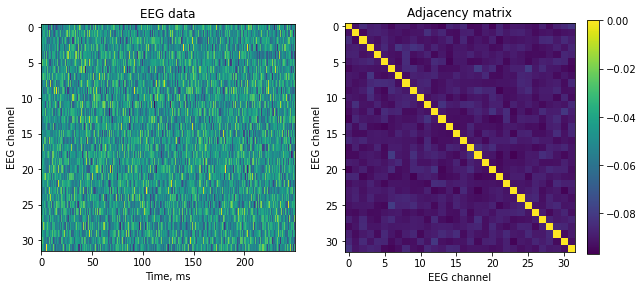

In [12]:
# Let us visualize both EEG data and FC data of a randomly taken data point
data = random.choice(dataset)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = [10,10])

ax1.imshow(data.x, interpolation = 'nearest', aspect = 7.)
ax1.set_xlabel('Time, ms')
ax1.set_ylabel('EEG channel')
ax1.set_title('EEG data')

im = ax2.imshow(data.adj[0])
ax2.set_xlabel('EEG channel')
ax2.set_ylabel('EEG channel')
ax2.set_title('Adjacency matrix')
fig.colorbar(im, fraction = 0.046);

### Train/test split

In [13]:
random.shuffle(dataset)

train_dataset = dataset[:8*len(dataset)//10] # First 80% of data
test_dataset = dataset[8*len(dataset)//10:] # Last 20% of data

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True, drop_last=True)

Number of training graphs: 1728
Number of test graphs: 432


/home/zhdano82/.conda/envs/geometric/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# Training a model

In [14]:
from model import ccVAE
from utils import train

In [15]:
# A class containing hyperparameters of a model. Mimics argsparse.
class Args():
    def __init__(self, z_dim = 10, w_dim = 10):
        self.n_nodes = N
        self.x_dim = 250
        self.n_classes = 3 # len(y)
        
        self.z_dim = z_dim
        self.w_dim = w_dim
        
        self.elbo_coefs = [1.,2.,10.] # beta_z, beta_w, alpha_classifier (see Thesis, 3.3.2)
        self.decoder_w_mode = 'conv'
        self.cond_prior_w_mode = 'lookup'
        self.cond_prior_z_mode = 'lookup'
        
        self.use_cuda = 1

In [16]:
# Initialize model
args = Args()
model = ccVAE(args).cuda()

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [18]:
# Let us train a model now
n_epochs = 3
for epoch in range(n_epochs):
    train(model, optimizer, train_loader, True, 'cuda', 1) # training procedure
    if epoch % 5 == 0:
        train(model, optimizer, test_loader, False, 'cuda', 1) # testing procedure

ELBO 9068.58, Accuracy y: [0.55, 0.63, 0.31] MSE X: 1092.74, MSE A: 103.99, KL Z: 184.21, KL W: 5.99, log q(y|X,A): 0.23, 
Test
ELBO 8993.74, Accuracy y: [0.53, 0.69, 0.26] MSE X: 978.98, MSE A: 96.68, KL Z: 173.86, KL W: 5.94, log q(y|X,A): 0.35, 
ELBO 8510.86, Accuracy y: [0.55, 0.59, 0.26999998] MSE X: 153.10, MSE A: 20.00, KL Z: 180.85, KL W: 6.04, log q(y|X,A): 0.20, 
ELBO 8424.69, Accuracy y: [0.48999998, 0.61, 0.28] MSE X: 87.32, MSE A: 5.55, KL Z: 179.07, KL W: 6.16, log q(y|X,A): 0.28, 
